In [16]:
import numpy as np
import time
import math
import os
import scipy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, RidgeCV, Lasso, SGDRegressor, ElasticNet, MultiTaskElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor




## Reproducability
seed = 42
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


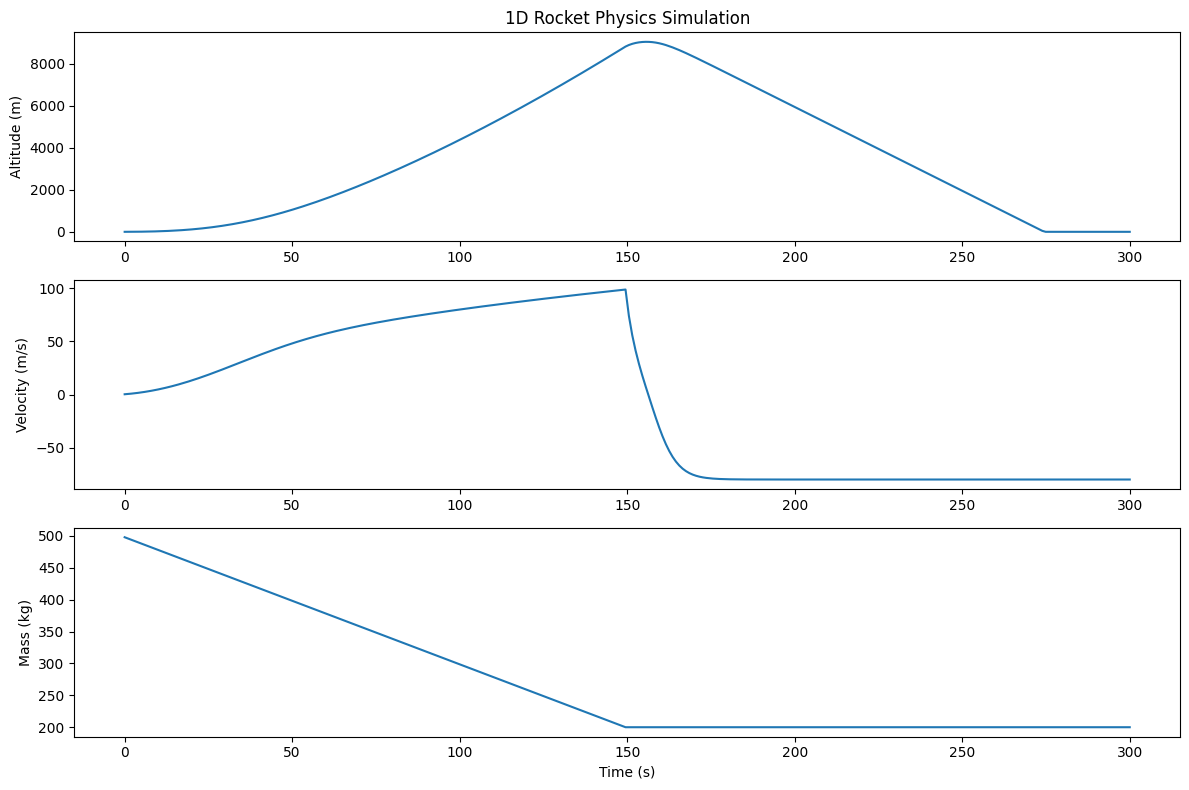

In [17]:
# Physical constants
G = 9.81  # gravity (m/s²)
AIR_DENSITY = 1.225  # kg/m³ (air density at sea level)


# Rocket parameters
drag_coefficient = 0.5    # simplified drag coefficient
rocket_area = 1.0         # cross-sectional area (m²)
initial_mass = 500.0      # kg (total mass at liftoff)
fuel_mass = 300.0         # kg of fuel
burn_rate = 2.0           # kg/s (fuel consumption rate)
thrust = 5000.0           # N (constant thrust while fuel remains)




def rocket_simulation(rocket_area, initial_mass, fuel_mass, burn_rate, thrust, drag_coefficient):
    """ Simulates a 1D rocket launch and descent with constant thrust and drag. """

    # Initial conditions
    altitude = 0.1
    velocity = 0.0
    mass = initial_mass
    time = 0.0
    dt = 1  # time step (s)
    t_max = 300  # simulation duration (s)
    
    # State arrays
    altitudes = []
    velocities = []
    accelerations = []
    masses = []
    times = []

    # Simulation loop
    for time in np.linspace(0, t_max, int(t_max / dt)):
        
        # Update mass based on fuel consumption
        if fuel_mass > 0:
            dm = burn_rate * dt
            if dm > fuel_mass:
                dm = fuel_mass  # consume remaining fuel only
            fuel_mass -= dm
            mass -= dm
            current_thrust = thrust
        else:
            current_thrust = 0

        # Forces
        weight = mass * G
        drag = 0.5 * rocket_area * drag_coefficient * AIR_DENSITY * velocity**2 * np.sign(velocity)
        net_force = current_thrust - weight - drag
        acceleration = net_force / mass

        # Euler integration
        velocity += acceleration * dt
        altitude += velocity * dt

        # Store state
        times.append(time)
        altitudes.append(max(altitude, 0))  # avoid negative altitude display
        velocities.append(velocity)
        accelerations.append(acceleration)
        masses.append(mass)
        
    return times, altitudes, velocities, masses


times, altitudes, velocities, masses = rocket_simulation(rocket_area, initial_mass, fuel_mass, burn_rate, thrust, drag_coefficient)

# Plotting results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(times, altitudes)
plt.ylabel("Altitude (m)")
plt.title("1D Rocket Physics Simulation")

plt.subplot(3, 1, 2)
plt.plot(times, velocities)
plt.ylabel("Velocity (m/s)")

plt.subplot(3, 1, 3)
plt.plot(times, masses)
plt.ylabel("Mass (kg)")
plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()


In [18]:


def generate_random_params():
    rocket_area = np.random.uniform(0.5, 2.0)
    initial_mass = np.random.uniform(300, 800)
    fuel_mass = np.random.uniform(0.1, 0.7) * initial_mass 
    burn_rate = np.random.uniform(1, 10)
    # thrust = np.random.uniform(100, 1000)
    thrust = 100 * fuel_mass
    drag_coefficient = np.random.uniform(0.1, 1.0)
    
    return [rocket_area, initial_mass, fuel_mass, burn_rate, thrust, drag_coefficient]


X = []
Y = []
for _ in range(1000):
    params = generate_random_params()
    _, altitudes, _, _ = rocket_simulation(*params)
        
    if np.isnan(altitudes).any():
        print("Simulation failed due to NaN altitude.")
        print("Altitudes : ", altitudes)
        break
        
    X.append(params)
    Y.append(altitudes)

X = np.array(X)
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=True)

print("Training set size:", X_train.shape, Y_train.shape)
print("Test set size:", X_test.shape, Y_test.shape)


# Standardiser X
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


Training set size: (800, 6) (800, 300)
Test set size: (200, 6) (200, 300)


Training time: 0.16s

Model's R2 score : 0.983
FINAL RMSE: 1946.846



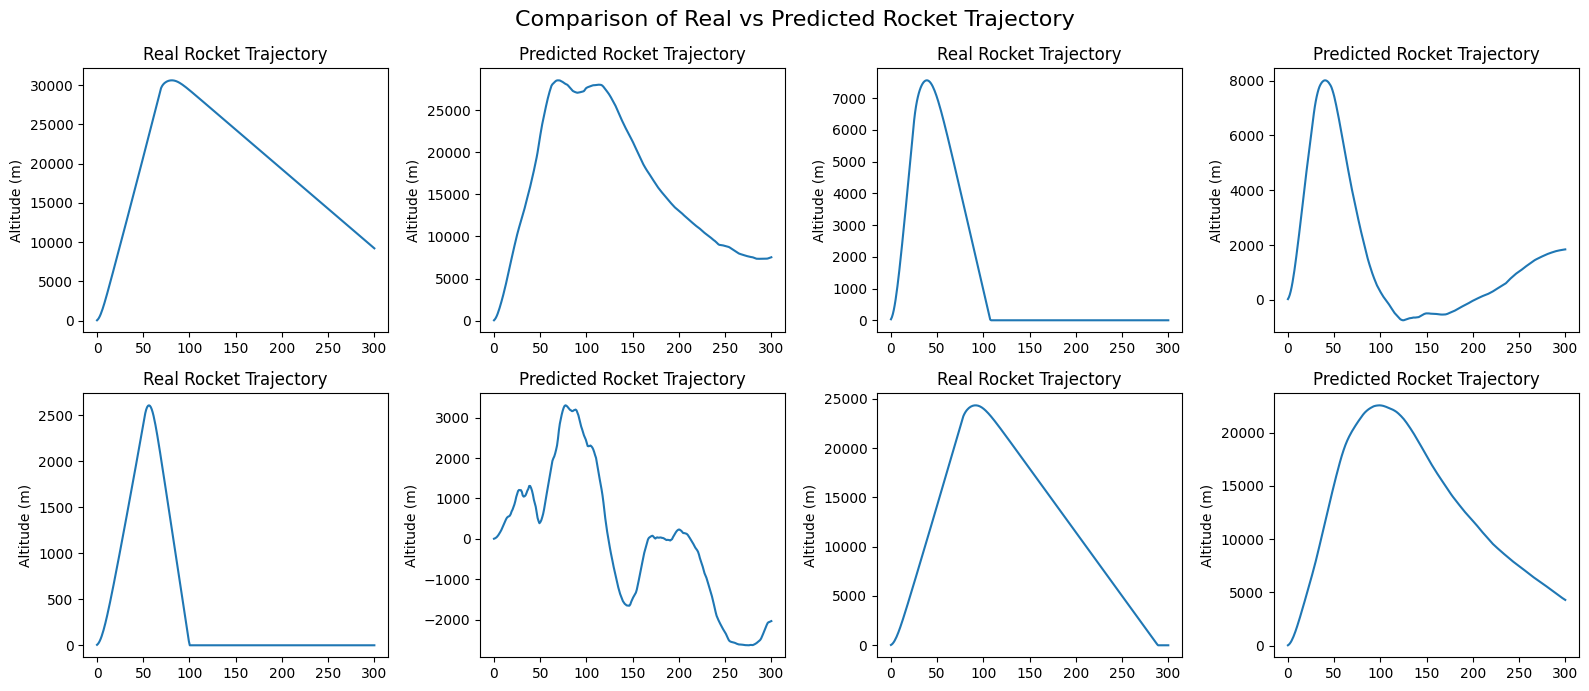

In [19]:
# model = LinearRegression(n_jobs=-1) 
model = make_pipeline(PolynomialFeatures(5), StandardScaler(), LinearRegression(n_jobs=-1)) # 1946
# model = make_pipeline(PolynomialFeatures(5), MultiOutputRegressor(SGDRegressor())) # 6e10
# model = make_pipeline(PolynomialFeatures(3), RandomForestRegressor()) # 2611
# model = make_pipeline(PolynomialFeatures(3), ExtraTreesRegressor(n_estimators=100, n_jobs=-1)) # 1979
# model = make_pipeline(PolynomialFeatures(3), XGBRegressor(n_estimators=100, n_jobs=-1)) # (too long)
# model = make_pipeline(PolynomialFeatures(3), KNeighborsRegressor(n_neighbors=5)) # 12058
# model = make_pipeline(PolynomialFeatures(3), GaussianProcessRegressor()) # 15184
# model = make_pipeline(PolynomialFeatures(3), MultiOutputRegressor(SVR(kernel='rbf'))) # 14466
# model = make_pipeline(PolynomialFeatures(3), Ridge()) # 3273
# model = make_pipeline(PolynomialFeatures(3), Lasso()) # 3332
# model = make_pipeline(PolynomialFeatures(3), ElasticNet()) # 1000
# model = MLPRegressor(hidden_layer_sizes=(128, 256), activation='relu', max_iter=500, random_state=seed, early_stopping=True) # 11462


start = time.perf_counter()
history = model.fit(X_train, Y_train)
end = time.perf_counter()
exe_time = end - start          
print(f"Training time: {exe_time:.2f}s\n") 





### EVALUATION
score = model.score(X_test, Y_test)
print(f"Model's R2 score : {score:.3f}")

Y_predict = model.predict(X_test) 
print(f"FINAL RMSE: {np.sqrt(mean_squared_error(Y_test, Y_predict)):.3f}\n")


## PLOT RANDOM PREDICTIONS
fig, ax = plt.subplots(2, 4, figsize=(16, 7))
fig.suptitle("Comparison of Real vs Predicted Rocket Trajectory", fontsize=16)

for idx, i in enumerate([31, 47, 122, 180]):
    plt.subplot(241 + 2*idx)
    plt.plot(times, Y_test[i])
    plt.ylabel("Altitude (m)")
    plt.title("Real Rocket Trajectory")

    plt.subplot(242 + 2*idx)
    plt.plot(times, Y_predict[i])
    plt.ylabel("Altitude (m)")
    plt.title("Predicted Rocket Trajectory")

plt.tight_layout()
plt.show()


RMSE: 13247.49841231708
R2: -0.00040289761299397507


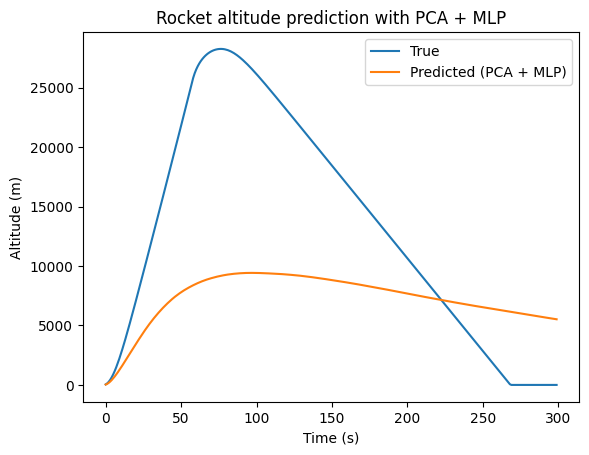

In [20]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score




# Réduction de dimension sur la sortie Y avec PCA
k = 10  # nombre de composantes principales à prédire
pca = PCA(n_components=k)
Y_train_pca = pca.fit_transform(Y_train)
Y_test_pca = pca.transform(Y_test)

# Régression pour prédire les composantes principales
regressor = MLPRegressor(
    hidden_layer_sizes=(128, 128),
    activation='relu',
    max_iter=500,
    early_stopping=True,
    random_state=42,
    verbose=False
)

regressor.fit(X_train_scaled, Y_train_pca)

# Prédiction des composantes réduites
Y_pred_pca = regressor.predict(X_test_scaled)

# Reconstruction des courbes complètes (300 points) à partir des k composantes
Y_pred_full = pca.inverse_transform(Y_pred_pca)

# Évaluation
print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred_full)))
print("R2:", r2_score(Y_test, Y_pred_full))

# Affichage pour un échantillon
i = 0
plt.plot(Y_test[i], label="True")
plt.plot(Y_pred_full[i], label="Predicted (PCA + MLP)")
plt.title("Rocket altitude prediction with PCA + MLP")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.legend()
plt.show()


5 0.9827684417429762
[-0.00040318919003195104, 0.6433448049514726, 0.8925297650197777, 0.9535076066829559, 0.9713256784557064, 0.9827684417429762, 0.9713407909661023, -6.0789376477726815, 0.22163765688162926, -0.4049875821329838]


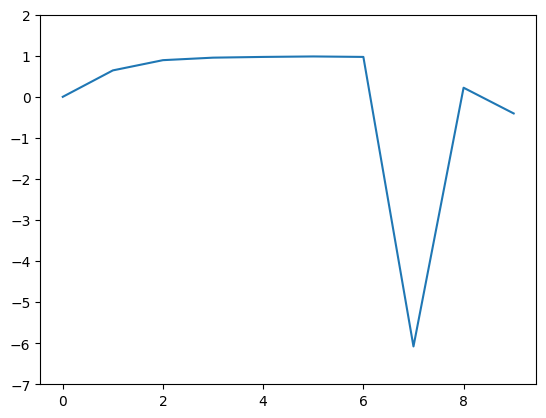

In [21]:
degree = list(range(10))
scores = []

for i in degree:
    # model = make_pipeline(PolynomialFeatures(i), LinearRegression(n_jobs=-1))
    model = make_pipeline(PolynomialFeatures(i), StandardScaler(), LinearRegression(n_jobs=-1))
    model.fit(X_train, Y_train)
    scores.append(model.score(X_test, Y_test))
    
print(scores.index(max(scores)), max(scores))
print(scores)

plt.plot(degree, scores)
plt.ylim([-7, 2])
plt.show()